## Introduction
In this project, we embark on an exciting journey to transform ordinary photographs into stunning Monet-style artworks using CycleGAN, a powerful deep learning framework. CycleGAN (Cycle-Consistent Generative Adversarial Network) is a state-of-the-art technique that enables image-to-image translation without requiring paired examples. By leveraging two generators and two discriminators, CycleGAN learns the mapping between two different image domains while preserving the essential content and style. Through this notebook, we will explore the intricate components of CycleGAN, including the generators, discriminators, and various loss functions that ensure high-quality and consistent image translations. Finally, we will visualize the transformation by comparing input photographs with their Monet-inspired outputs, witnessing the power of artificial intelligence in creating digital art.

### Importing Necessary Libraries

In this section, we import the necessary libraries for building and training our Generative Adversarial Network (GAN) model. These include TensorFlow and Keras for model building, Matplotlib for visualization, and NumPy for numerical operations.

### Listing TFRecord Files

We then list the TFRecord files containing the datasets for training our GAN. The TFRecord files for Monet and photo images are assumed to be located in `monet_tfrec` and `photo_tfrec` folders, respectively, within the current directory.

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import GroupNormalization
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Assuming the TFRecord files are located in 'monet_tfrec' and 'photo_tfrec' folders within the current directory
MONET_FILENAMES = tf.io.gfile.glob('./monet_tfrec/*.tfrec')
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob('./photo_tfrec/*.tfrec')
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))


Monet TFRecord Files: 5
Photo TFRecord Files: 20


### Data Preparation

In this section, we prepare the image data for training the GAN model. This involves defining functions to decode and parse the TFRecord files and load the datasets.

#### Image Decoding

The `decode_image` function decodes JPEG images from the TFRecord files, rescales the pixel values to the range [-1, 1], and resizes the images to 128x128 pixels.


In [38]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3) # 3 channels for RGB
    image = (tf.cast(image, tf.float32) / 127.5) - 1 # rescale each channel to [-1,1]
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    image = tf.image.resize(image, [128, 128])  # Resize to 128x128
    return image

#function to parse a TFRecord file's structure. This is passed into the dataset.map function for decoding
def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

#function to load the entire dataset from each TFRecord. Maps using the above TFRecord file structure
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

### Loading and Visualizing the Datasets

In this section, we load the datasets and visualize example images from the Monet and photo datasets to ensure that the data is correctly processed and ready for training.

#### Loading the Datasets

We use the `load_dataset` function to load the Monet and photo datasets from the TFRecord files. The datasets are batched with a batch size of 1.

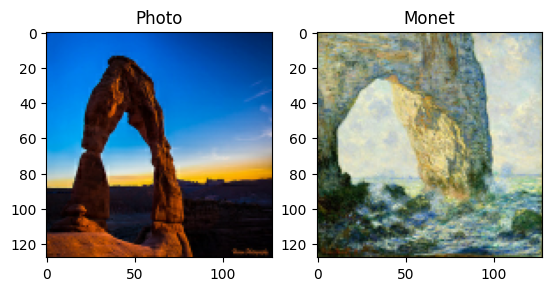

In [39]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

plt.subplot(121)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

### Defining the Downsampling Layer

In this section, we define a downsampling layer, which is a crucial component of the generator and discriminator networks in the GAN model. The downsampling layer reduces the spatial dimensions of the input image while increasing the number of filters, effectively capturing important features at various scales.

#### Downsampling Function

The `downsample` function creates a downsampling layer using Keras' `Sequential` API. This layer consists of a convolutional layer followed by optional batch normalization and a Leaky ReLU activation function.

In [40]:
def downsample(filters, size, i, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = keras.Sequential(name=f'downsample_{i}')
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(layers.BatchNormalization())

    result.add(layers.LeakyReLU())
    return result

## Function Explanation: `upsample`

The `upsample` function creates an upsampling layer for a neural network using TensorFlow and Keras. This function is designed to increase the spatial dimensions (height and width) of an input tensor while applying a series of transformations to enhance the feature representations.

In [41]:
def upsample(filters, size, i, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = keras.Sequential(name=f'Upsample_{i}')
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tf.keras.layers.GroupNormalization(groups=-1))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

## Function Explanation: `Generator`

The `Generator` function constructs a generator model for a neural network, typically used in Generative Adversarial Networks (GANs) for generating images. The generator takes an input image, processes it through a series of downsampling and upsampling layers, and outputs an image with the same dimensions but modified content. 

In [42]:
OUTPUT_CHANNELS = 3
def Generator():
    inputs = layers.Input(shape=[128, 128, 3])  # Reduced resolution
    down_stack = [
        downsample(64, 4, 1, apply_instancenorm=False), # (bs, 64, 64, 64)
        downsample(128, 4, 2), # (bs, 32, 32, 128)
        downsample(256, 4, 3), # (bs, 16, 16, 256)
    ]
    up_stack = [
        upsample(128, 4, 1), # (bs, 32, 32, 128)
        upsample(64, 4, 2), # (bs, 64, 64, 64)
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4, strides=2, padding='same',
                                  kernel_initializer=initializer, activation='tanh') # (bs, 128, 128, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        if skip is not None:
            x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)


In [43]:
test_generator = Generator()
test_generator.summary()

Model: "functional_142"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_109     │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ downsample_1        │ (None, 64, 64,    │      3,072 │ input_layer_109[… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ downsample_2        │ (None, 32, 32,    │    131,584 │ downsample_1[0][… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ downsample_3        │ (None, 16, 16,    │    525,312 │ downsample_2[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Upsample_1          │ (None, 32, 32,    │    524,544 │ downsample_3[0][… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_31      │ (None, 32, 32,    │          0 │ Upsample_1[0][0], │
│ (Concatenate)       │ 256)              │            │ downsample_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Upsample_2          │ (None, 64, 64,    │    262,272 │ concatenate_31[0… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_32      │ (None, 64, 64,    │          0 │ Upsample_2[0][0], │
│ (Concatenate)       │ 128)              │            │ downsample_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_41 │ (None, 128, 128,  │      6,147 │ concatenate_32[0… │
│ (Conv2DTranspose)   │ 3)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,452,931 (5.54 MB)

 Trainable params: 1,452,163 (5.54 MB)

 Non-trainable params: 768 (3.00 KB)

## Function Explanation: `Discriminator`

The `Discriminator` function constructs a discriminator model for a neural network, typically used in Generative Adversarial Networks (GANs). The discriminator's role is to differentiate between real and generated (fake) images.

In [44]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = layers.Input(shape=[128, 128, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, 1, False)(x)  # (bs, 64, 64, 64)
    down2 = downsample(128, 4, 2)(down1)  # (bs, 32, 32, 128)
    down3 = downsample(256, 4, 3)(down2)  # (bs, 16, 16, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3)  # (bs, 18, 18, 256)
    conv = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)  # (bs, 15, 15, 512)
    norm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)  # (bs, 17, 17, 512)
    last = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)  # (bs, 14, 14, 1)

    return tf.keras.Model(inputs=inp, outputs=last)




In [45]:
test_discriminator = Discriminator()
test_discriminator.summary()

Model: "functional_147"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ downsample_1 (Sequential)       │ (None, 64, 64, 64)     │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ downsample_2 (Sequential)       │ (None, 32, 32, 128)    │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ downsample_3 (Sequential)       │ (None, 16, 16, 256)    │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_20               │ (None, 18, 18, 256)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_137 (Conv2D)             │ (None, 15, 15, 512)    │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 15, 15, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_127 (LeakyReLU)     │ (None, 15, 15, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_21               │ (None, 17, 17, 512)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_138 (Conv2D)             │ (None, 14, 14, 1)      │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,767,361 (10.56 MB)

 Trainable params: 2,765,569 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

## Class Explanation: `CycleGan`

The `CycleGan` class implements the CycleGAN architecture, which is used for image-to-image translation tasks where paired training data is not available. This model consists of two generators and two discriminators that work together to translate images from one domain to another and back, ensuring the consistency of the translation.

In [46]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

## Initialization of CycleGAN Components

In this section, we initialize the components required for training the CycleGAN model. This includes the generators, discriminators, and optimizers.

In [47]:
monet_generator = Generator() # photograph -> Monet
photo_generator = Generator() # Monet -> photograph

monet_discriminator = Discriminator() # differentiates real and generated Monet paintings
photo_discriminator = Discriminator() # differentiates real and generated photographs

monet_generator_optimizer = Adam(1e-4, beta_1=0.5)
photo_generator_optimizer = Adam(1e-4, beta_1=0.5)

monet_discriminator_optimizer = Adam(1e-4, beta_1=0.5)
photo_discriminator_optimizer = Adam(1e-4, beta_1=0.5)

## Discriminator Loss Function

In this section, we define the loss function for the discriminators used in the CycleGAN model. The discriminator's goal is to correctly distinguish between real images and generated (fake) images. The loss function helps in quantifying how well the discriminator is performing this task.

In [48]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5


## Generator Loss Function

In this section, we define the loss function for the generators used in the CycleGAN model. The generator's goal is to create realistic images that can fool the discriminator. The loss function helps in quantifying how well the generator is performing this task.

In [49]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

## Cycle Consistency Loss Function

In this section, we define the cycle consistency loss function used in the CycleGAN model. The purpose of the cycle consistency loss is to ensure that an image translated to another domain and back (cycled image) should be close to the original image (real image). This helps in maintaining the content of the images during translation.

In [50]:
def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA * loss1

## Identity Loss Function

In this section, we define the identity loss function used in the CycleGAN model. The identity loss ensures that when an image is passed through the generator of its own domain, it remains unchanged. This helps in preserving the color and style consistency of the images.


In [51]:
def identity_loss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss


## Instantiating and Training the CycleGAN

In this section, we instantiate the `CycleGan` model, compile it with the necessary components and loss functions, train the model on the dataset, and save the trained Monet generator.


In [52]:
#instantiate the cycleGAN
cycle_gan_model = CycleGan(
    monet_generator, photo_generator, monet_discriminator, photo_discriminator
)

cycle_gan_model.compile(
    m_gen_optimizer = monet_generator_optimizer,
    p_gen_optimizer = photo_generator_optimizer,
    m_disc_optimizer = monet_discriminator_optimizer,
    p_disc_optimizer = photo_discriminator_optimizer,
    gen_loss_fn = generator_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss
)

#train the cycleGAN on the dataset
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=25,
)

monet_generator.save("Monet_Generator.keras")


Epoch 1/25
    300/Unknown 471s 1s/step - monet_disc_loss: 0.6874 - monet_gen_loss: 6.3001 - photo_disc_loss: 0.6769 - photo_gen_loss: 6.3756

2024-06-28 16:07:19.681393: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 471s 1s/step - monet_disc_loss: 0.6870 - monet_gen_loss: 6.2930 - photo_disc_loss: 0.6763 - photo_gen_loss: 6.3696
Epoch 2/25


/Users/sakshamkapoor/miniconda3/lib/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


300/300 ━━━━━━━━━━━━━━━━━━━━ 425s 1s/step - monet_disc_loss: 0.6270 - monet_gen_loss: 4.4270 - photo_disc_loss: 0.6372 - photo_gen_loss: 4.3843
Epoch 3/25


2024-06-28 16:14:24.547297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 487s 2s/step - monet_disc_loss: 0.6073 - monet_gen_loss: 3.9429 - photo_disc_loss: 0.6161 - photo_gen_loss: 3.8670
Epoch 4/25


2024-06-28 16:22:31.200161: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 468s 2s/step - monet_disc_loss: 0.5972 - monet_gen_loss: 3.7148 - photo_disc_loss: 0.6014 - photo_gen_loss: 3.6530
Epoch 5/25


2024-06-28 16:30:19.136672: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - monet_disc_loss: 0.5886 - monet_gen_loss: 3.6660 - photo_disc_loss: 0.5917 - photo_gen_loss: 3.6071

2024-06-28 16:40:18.467996: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 600s 2s/step - monet_disc_loss: 0.5881 - monet_gen_loss: 3.6680 - photo_disc_loss: 0.5910 - photo_gen_loss: 3.6077
Epoch 6/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 596s 2s/step - monet_disc_loss: 0.5817 - monet_gen_loss: 3.6455 - photo_disc_loss: 0.5833 - photo_gen_loss: 3.5878
Epoch 7/25


2024-06-28 16:50:14.442962: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - monet_disc_loss: 0.5800 - monet_gen_loss: 3.6194 - photo_disc_loss: 0.5773 - photo_gen_loss: 3.5769

2024-06-28 16:59:05.429591: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 531s 2s/step - monet_disc_loss: 0.5796 - monet_gen_loss: 3.6222 - photo_disc_loss: 0.5767 - photo_gen_loss: 3.5779
Epoch 8/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 551s 2s/step - monet_disc_loss: 0.5777 - monet_gen_loss: 3.5970 - photo_disc_loss: 0.5695 - photo_gen_loss: 3.5692
Epoch 9/25


2024-06-28 17:08:16.421082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - monet_disc_loss: 0.5747 - monet_gen_loss: 3.5649 - photo_disc_loss: 0.5629 - photo_gen_loss: 3.5565

2024-06-28 17:18:05.460747: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 589s 2s/step - monet_disc_loss: 0.5744 - monet_gen_loss: 3.5674 - photo_disc_loss: 0.5623 - photo_gen_loss: 3.5572
Epoch 10/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 601s 2s/step - monet_disc_loss: 0.5703 - monet_gen_loss: 3.5432 - photo_disc_loss: 0.5552 - photo_gen_loss: 3.5466
Epoch 11/25


2024-06-28 17:28:06.692750: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 490s 2s/step - monet_disc_loss: 0.5657 - monet_gen_loss: 3.5270 - photo_disc_loss: 0.5476 - photo_gen_loss: 3.5427
Epoch 12/25


2024-06-28 17:36:16.623186: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - monet_disc_loss: 0.5649 - monet_gen_loss: 3.5202 - photo_disc_loss: 0.5414 - photo_gen_loss: 3.5464

2024-06-28 17:44:27.580657: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 491s 2s/step - monet_disc_loss: 0.5649 - monet_gen_loss: 3.5229 - photo_disc_loss: 0.5410 - photo_gen_loss: 3.5470
Epoch 13/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 512s 2s/step - monet_disc_loss: 0.5625 - monet_gen_loss: 3.5147 - photo_disc_loss: 0.5347 - photo_gen_loss: 3.5497
Epoch 14/25


2024-06-28 17:53:00.298803: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 507s 2s/step - monet_disc_loss: 0.5590 - monet_gen_loss: 3.4946 - photo_disc_loss: 0.5317 - photo_gen_loss: 3.5448
Epoch 15/25


2024-06-28 18:01:27.685893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 526s 2s/step - monet_disc_loss: 0.5557 - monet_gen_loss: 3.4956 - photo_disc_loss: 0.5246 - photo_gen_loss: 3.5506
Epoch 16/25


2024-06-28 18:10:13.830266: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 492s 2s/step - monet_disc_loss: 0.5513 - monet_gen_loss: 3.4906 - photo_disc_loss: 0.5181 - photo_gen_loss: 3.5487
Epoch 17/25


2024-06-28 18:18:25.809364: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 355s 1s/step - monet_disc_loss: 0.5433 - monet_gen_loss: 3.5027 - photo_disc_loss: 0.5130 - photo_gen_loss: 3.5536
Epoch 18/25


2024-06-28 18:24:20.428269: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 376s 1s/step - monet_disc_loss: 0.5377 - monet_gen_loss: 3.5494 - photo_disc_loss: 0.5103 - photo_gen_loss: 3.5914
Epoch 19/25


2024-06-28 18:30:36.268329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 341s 1s/step - monet_disc_loss: 0.5332 - monet_gen_loss: 3.5467 - photo_disc_loss: 0.5057 - photo_gen_loss: 3.5978
Epoch 20/25


2024-06-28 18:36:17.354068: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 328s 1s/step - monet_disc_loss: 0.5246 - monet_gen_loss: 3.5698 - photo_disc_loss: 0.5018 - photo_gen_loss: 3.6258
Epoch 21/25


2024-06-28 18:41:45.468771: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 349s 1s/step - monet_disc_loss: 0.5218 - monet_gen_loss: 3.6102 - photo_disc_loss: 0.4912 - photo_gen_loss: 3.6703
Epoch 22/25


2024-06-28 18:47:34.736646: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 348s 1s/step - monet_disc_loss: 0.5211 - monet_gen_loss: 3.6249 - photo_disc_loss: 0.4901 - photo_gen_loss: 3.6825
Epoch 23/25


2024-06-28 18:53:22.835980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 330s 1s/step - monet_disc_loss: 0.5158 - monet_gen_loss: 3.6640 - photo_disc_loss: 0.4831 - photo_gen_loss: 3.7259
Epoch 24/25


2024-06-28 18:58:52.907394: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 377s 1s/step - monet_disc_loss: 0.5020 - monet_gen_loss: 3.6800 - photo_disc_loss: 0.4882 - photo_gen_loss: 3.7402
Epoch 25/25


2024-06-28 19:05:10.374039: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


300/300 ━━━━━━━━━━━━━━━━━━━━ 330s 1s/step - monet_disc_loss: 0.5007 - monet_gen_loss: 3.7158 - photo_disc_loss: 0.4844 - photo_gen_loss: 3.7783


2024-06-28 19:10:39.978206: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


## Visualizing the Results

In this section, we visualize the results of the trained CycleGAN model by comparing input photos with their corresponding Monet-style outputs generated by the model.


2024-06-28 19:15:43.837364: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


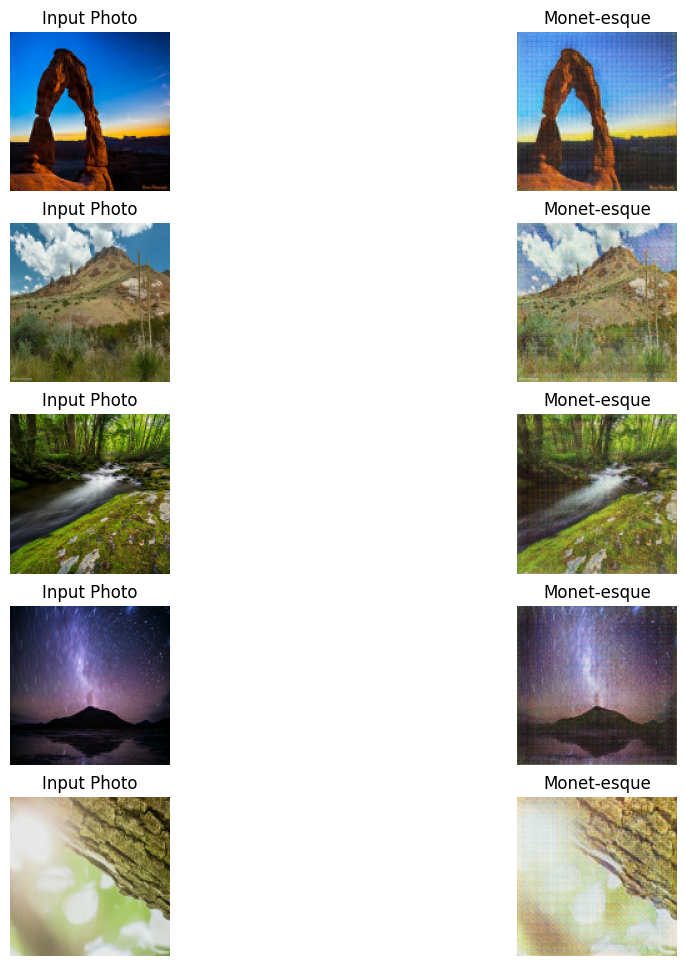

In [53]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

In [54]:
import os
import numpy as np
from PIL import Image
import shutil

# Create a directory for saving generated images
os.makedirs('../images', exist_ok=True)

# Assuming `photo_ds` contains your dataset of photos
i = 1
for img in photo_ds:
    # Replace `monet_generator` with your actual function/model for generating Monet-style images
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = Image.fromarray(prediction)
    im.save(f"../images/{i}.jpg")
    i += 1

# Create a zip archive of the images
shutil.make_archive("../images", 'zip', "../images")


2024-06-28 19:26:58.088760: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


'/Users/sakshamkapoor/Downloads/images.zip'

## Conclusion
This project showcases the incredible potential of CycleGAN in transforming ordinary photographs into mesmerizing Monet-style paintings. By carefully constructing and training the CycleGAN model, we have demonstrated the ability to perform complex image-to-image translations while preserving the original content and style. The visual results highlight the effectiveness of the model, revealing the detailed and artistic quality of the generated images. This project not only underscores the advancements in generative adversarial networks but also opens up new possibilities for digital art creation and various applications in fields such as photography, entertainment, and virtual reality. As we continue to refine and expand these techniques, the boundary between real and generated imagery will become increasingly seamless, offering unprecedented creative opportunities.